In [1]:
import random

import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.multiprocessing as mp
from tqdm import tqdm, trange
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import sys
sys.path.append("../")
from src.models.train_model import ratings_dataloader, MatrixFactorization

In [7]:
torch.cuda.empty_cache()

In [2]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
df = pd.read_csv("../data/interim/small_10000_orders_weighted_adjacency_matrix.csv")
df["rating"] = df.weight

5 Most Purchased Products:
       product_id  weight
3169        13176    1307
5904        24852    1305
5228        21903     963
5032        21137     861
11221       47209     785


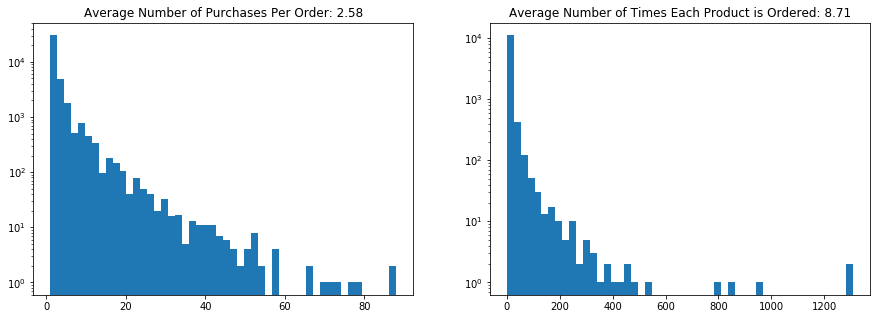

In [4]:
df_grouped = df[["product_id", "weight"]].groupby(["product_id"]).sum()
df_grouped.reset_index(inplace=True)
print(
    f"5 Most Purchased Products:\n{df_grouped.sort_values(by='weight', ascending=False).head(5)}"
)

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.hist(df.weight, bins=50)
ax1.set_yscale("log")
ax1.set_title(f"Average Number of Purchases Per Order: {df.weight.mean():.2f}")

ax2.hist(df_grouped.weight, bins=50)
ax2.set_title(
    f"Average Number of Times Each Product is Ordered: {df_grouped.weight.mean():.2f}"
)
ax2.set_yscale("log")

plt.show()

## Collaborative Filtering

For the models we will want to use a numeric index rather than the product_id and user_id so that we can easily match the embedding vector with the user or product.

In [9]:
epochs = 100
print_every = 1
embedding_dim = 25
l2 = 0
lr = 0.0001
# loss_fn = nn.BCEWithLogitsLoss
loss_fn = nn.MSELoss
dataframe = df.sample(500, random_state=23)  # here we are only taking 500 interactions
num_negs = 0
bs = 500

(tr_load, va_load, te_load), n_users, n_prod = ratings_dataloader(dataframe, batch_size=bs, dev=dev, num_negs=num_negs)

model = MatrixFactorization(
        n_users, n_prod, n_factors=embedding_dim, lr=lr, l2=l2, loss_fn=loss_fn
    ).to(dev)

In [ ]:
for epoch in range(epochs):
    train_loss, train_accuracy = model.train_model(tr_load)
    val_loss, val_accuracy = model.evaluate(va_load)

    if (epoch + 1) % print_every == 0:
        print(
            f"epoch #{epoch + 1}, "
            f"training loss: {train_loss:0.3f}, "
            f"training accuracy: {train_accuracy}, "
            f"validation loss: {val_loss:0.3f}, "
            f"validation accuracy: {val_accuracy}, "
        )

epoch #1, training loss: 23.229, training accuracy: 51.00, validation loss: 21.035, validation accuracy: 46.00, 
epoch #2, training loss: 23.228, training accuracy: 51.00, validation loss: 21.035, validation accuracy: 46.00, 
epoch #3, training loss: 23.227, training accuracy: 51.00, validation loss: 21.035, validation accuracy: 46.00, 


In [ ]:
sigmoid = nn.Sigmoid()
users_items = sigmoid(
    model.user_factors.weight @ model.product_factors.weight.transpose(0, 1)
)
values = users_items.detach().numpy()

plt.hist(values.ravel(), bins=50)
plt.show()

In [ ]:
def recommend_item_for_user(model, user_id):
    """
    
    """
    m = model.eval().cpu()

    user_ids = torch.LongTensor([user2idx[u] for u in [user_id] * len(items)])
    item_ids = torch.LongTensor([item2idx[b] for b in items])

    remove = set(ratings[ratings[user_col] == user_id][item_col].values)

    preds = m(user_ids, item_ids).detach().numpy()
    pred_item = [
        (p, b) for p, b in sorted(zip(preds, items), reverse=True) if b not in remove
    ]

    return pred_item


def recommend_user_for_item(model, item_id):
    """
    
    """
    m = model.eval().cpu()

    user_ids = torch.LongTensor([user2idx[u] for u in users])
    book_ids = torch.LongTensor([item2idx[b] for b in [item_id] * len(users)])

    remove = set(ratings[ratings[item_col] == book_id][user_col].values)

    preds = m(user_ids, item_ids).detach().numpy()
    pred_user = [
        (p, u) for p, u in sorted(zip(preds, users), reverse=True) if u not in remove
    ]

    return pred_user